In [1]:
import os
import sys
sys.path.insert(0, os.path.relpath('../../../../..')) 



In [2]:

from recidiviz.calculator.modeling.population_projection.simulations.super_simulation_factory import SuperSimulationFactory
from recidiviz.calculator.modeling.population_projection.simulations.compartment_transitions import CompartmentTransitions
from recidiviz.calculator.modeling.population_projection.spark_policy import SparkPolicy
import pandas as pd
from functools import partial
import yaml
%config Completer.use_jedi = False

In [11]:
test_sim = SuperSimulationFactory.build_super_simulation('../state/VA/HB_2038/VAHB2038_model_inputs.yaml')
# test_sim.simulate_policy([], 'probation')

/Users/pacopoler/.local/share/virtualenvs/pulse-data-Jd9N3JcA/lib/python3.7/site-packages/google/cloud/bigquery/table.py:1770: UserWarning: A progress bar was requested, but there was an error loading the tqdm library. Please install tqdm to use the progress bar functionality.
  create_bqstorage_client=create_bqstorage_client,


outflows_data returned 84 results
transitions_data returned 50 results
total_population_data returned 132 results


[<AxesSubplot:title={'center':'compartment: pretrial\noutflow_to: probation'}>]

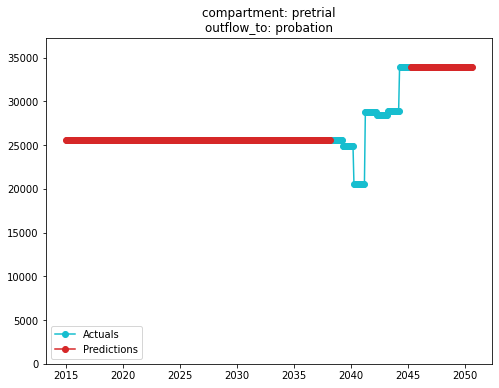

In [6]:
test_sim.gen_arima_output_plots('policy')

In [12]:
test_sim.data_dict['transitions_data'][test_sim.data_dict['transitions_data'].compartment == 'probation']

,simulation_tag,compartment_duration,compartment,outflow_to,total_population,crime,crime_type,age,race,date_created
4,VA_HB2038,22.0,probation,release,0.736795,None,NA,None,None,2021-02-10 21:28:39.653040+00:00
5,VA_HB2038,22.0,probation,release,0.736795,None,NA,None,None,2021-02-10 21:28:39.653040+00:00
6,VA_HB2038,1.0,probation,prison_newcrime,0.008887,None,NA,None,None,2021-02-10 21:28:39.653040+00:00
7,VA_HB2038,2.0,probation,prison_newcrime,0.008887,None,NA,None,None,2021-02-10 21:28:39.653040+00:00
8,VA_HB2038,3.0,probation,prison_newcrime,0.008887,None,NA,None,None,2021-02-10 21:28:39.653040+00:00
9,VA_HB2038,4.0,probation,prison_newcrime,0.008887,None,NA,None,None,2021-02-10 21:28:39.653040+00:00
10,VA_HB2038,5.0,probation,prison_newcrime,0.008887,None,NA,None,None,2021-02-10 21:28:39.653040+00:00
11,VA_HB2038,6.0,probation,prison_newcrime,0.008887,None,NA,None,None,2021-02-10 21:28:39.653040+00:00
12,VA_HB2038,7.0,probation,prison_newcrime,0.008887,None,NA,None,None,2021-02-10 21:28:39.653040+00:00
13,VA_HB2038,8.0,probation,prison_newcrime,0.008887,None,NA,None,None,2021-02-10 21:28:39.653040+00:00


initialization time:  24.572460174560547
simulation_time:  21.021374940872192
initialization time:  23.27804183959961
simulation_time:  19.219446897506714


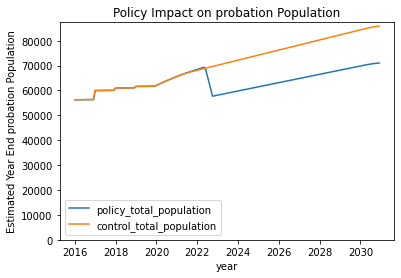

In [21]:
ONE_OR_FEWER_PRIOR_TECHNICALS = 0.66

CURRENT_PROBATION_CAP = 10 * 12
NEW_PROBATION_CAP = 5 * 12

CAP_AFFECTED_FRACTION = 0.4


# Policy Option Methods
def apply_cap_reduction(retroactive=False):
    return partial(CompartmentTransitions.apply_reduction, 
                   reduction_df=pd.DataFrame({'outflow': ['release'], 
                                              'affected_fraction': [1], 
                                              'reduction_size': [(1 - NEW_PROBATION_CAP / CURRENT_PROBATION_CAP) * CAP_AFFECTED_FRACTION]}),
                   reduction_type='*',
                   retroactive=retroactive)

def adjust_technical_revocations(retroactive=False):
    return partial(CompartmentTransitions.chop_technical_revocations,
                   technical_outflow='prison_technical',
                   retroactive=retroactive)

def reduce_technicals_re_incarceration(retroactive=False):
    return partial(CompartmentTransitions.reallocate_outflow, 
                   reallocation_df=pd.DataFrame({'outflow': ['prison_technical'], 'affected_fraction': [ONE_OR_FEWER_PRIOR_TECHNICALS], 
                                              'new_outflow': ['release']}),
                   reallocation_type='*',
                   retroactive=retroactive)




policy_list_non_retroactive = [
    SparkPolicy(policy_fn=apply_cap_reduction(),
                spark_compartment='probation',
                sub_population={'crime_type': 'NA'},
                apply_retroactive=False),
    SparkPolicy(policy_fn=adjust_technical_revocations(),
                spark_compartment='probation',
                sub_population={'crime_type': 'NA'},
                apply_retroactive=False),
    SparkPolicy(policy_fn=reduce_technicals_re_incarceration(),
                spark_compartment='probation',
                sub_population={'crime_type': 'NA'},
                apply_retroactive=False)
]
    
test_results = test_sim.simulate_policy(policy_list_non_retroactive, 'probation')


In [22]:
simulation_tag = 'VA_HB2038_40%'
test_sim.upload_simulation_results_to_bq('recidiviz-staging', simulation_tag)

In [14]:
test_sim.data_dict['transitions_data'].groupby(['compartment', 'outflow_to']).sum()

compartment_duration  total_population
compartment      outflow_to                                              
prison_newcrime  release                           37.0          1.000000
prison_technical release                           15.0          1.000000
probation        prison_newcrime                  861.0          0.263205
                 prison_technical                 861.0          0.263205
                 release                           82.0          1.473590
release          release                         1920.0          2.000000

In [10]:
test_sim.pop_simulations['policy'].sub_simulations['NA'].simulation_compartments['probation'].transition_tables.transition_dfs

{'before': outflow_to            prison_newcrime  prison_technical   release  remaining
 compartment_duration                                                        
 1                            0.003210          0.003210  0.000000   0.993580
 2                            0.003231          0.003231  0.000000   0.993539
 3                            0.003252          0.003252  0.000000   0.993497
 4                            0.003273          0.003273  0.000000   0.993454
 5                            0.003294          0.003294  0.000000   0.993411
 6                            0.003316          0.003316  0.000000   0.993367
 7                            0.003338          0.003338  0.000000   0.993323
 8                            0.003361          0.003361  0.000000   0.993278
 9                            0.003384          0.003384  0.000000   0.993233
 10                           0.003407          0.003407  0.000000   0.993187
 11                           0.003430          0.0034

In [6]:
test_sim.output_data['life_years']

,jail,release,prison
year,,,
2016,0.0,0.000000,0.000000
2017,0.0,0.000000,0.000000
2018,0.0,0.000000,0.000000
2019,0.0,0.000000,0.000000
2020,0.0,0.000000,0.000000
2021,0.0,0.000000,0.000000
2022,0.0,-409.277499,409.277498
2023,0.0,-983.956718,983.956715
2024,0.0,-1687.532192,1687.532187


In [7]:
test_sim.output_data['cost_avoidance']

,jail,release,prison
year,,,
2016,0.0,0.0,0.000000e+00
2017,0.0,0.0,0.000000e+00
2018,0.0,0.0,0.000000e+00
2019,0.0,0.0,0.000000e+00
2020,0.0,0.0,0.000000e+00
2021,0.0,0.0,0.000000e+00
2022,0.0,-0.0,1.315663e+07
2023,0.0,-0.0,3.163027e+07
2024,0.0,-0.0,5.424741e+07
